In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import cv2
from sklearn import metrics
import threading as th
from tqdm import tqdm as progress_bar

In [2]:
!ls


 best_circle_imgs
'best_circle_imgs (256color_faulty_lowerclip)'
'best_circle_imgs (256gray)'
'best_circle_imgs (copy)'
 best_so_far.png
 best_X_imgs
'download (1).png'
'download (2).png'
'download (3).png'
'download (4).png'
'download (5).png'
 download.png
 last_population_11k_with_sigmas.npy
 last_population_30k_with_sigmas.npy
 last_population.npy
 last_sigmas_11k.npy
 last_sigmas_30k.npy
 last_sigmas.npy
 Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF.jpg
 population_30k_kindaok.npy
 population_background.npy
 population_continuation_with_sigmas.npy
 population.npy
 projekt.ipynb
 projekt.ipynb.invalid
 README.md
 result_30k.png
 sigmas_continuation_with_sigmas.npy
 sigmas.npy
 todo.txt


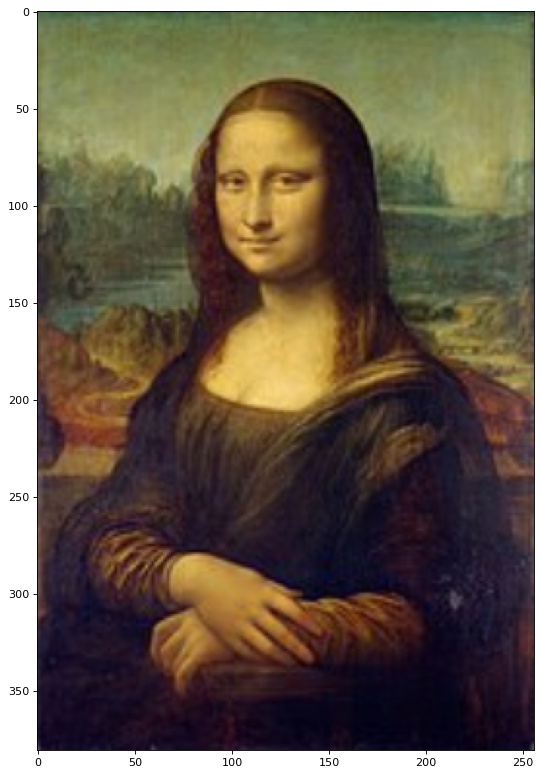

In [92]:
resize_to=256
#target_img=cv2.imread('./Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF.jpg')
target_img=cv2.imread('./mona.jpg')
target_img=cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
#target_img=target_img[300:-400, 300:-300] # cut borders

hw_ratio=target_img.shape[0]/target_img.shape[1]
target_img=cv2.resize(target_img, (resize_to, int(hw_ratio*resize_to))) # widtxXheight
target_img=np.asarray(target_img)/255


figure(figsize=(16, 12), dpi=80)
plt.imshow(target_img)#, cmap='gray')
plt.show()

# ES

In [93]:
def draw_individual(X_img, gray=True):
    figure(figsize=(4, 3), dpi=80)
    if gray:
        plt.imshow(X_img, cmap='gray')
    else:
        plt.imshow(X_img)
    plt.show()
def save_individual_img(X_img, gray=True, no_iter=0, dir_path='./best_circle_imgs/'):
    figure(figsize=(4, 3), dpi=80)
    if gray:
        plt.imshow(X_img, cmap='gray')
    else:
        plt.imshow(X_img)
    plt.savefig(dir_path+f'iter_{no_iter}')
    plt.show()

In [96]:
class EvoulationStrategy:
    def __init__(self, 
                initial_chromosome_length,
                genotype_length,
                population_size, 
                 
                target_img,
                gray=False,
                ):
        
        self.chromosome_length=initial_chromosome_length
        self.initial_chromosome_length=initial_chromosome_length
        self.genotype_length=genotype_length
        self.population_size=population_size
    
        self.target_img=target_img
        self.max_radius=np.sqrt(pow(self.target_img.shape[0],2)+pow(self.target_img.shape[1], 2))/2
        self.gray=gray
    
        self.population=None#np.empty((self.population_size, self.initil_chromosome_length, self.genotype_length))
        # circles already in good position, modify only those in self.population
        # preferably array representing image, to save time during eval
        self.population_background=None 
        self.sigmas=None#np.empty((self.population_size, self.genotype_length))
        self.curr_iter=0
        self.evals=None
        self.times_circles_were_added=0
        
        self.mutation_clip_lows=np.zeros(genotype_length)
      #  clip_highs=np.ones(solutions[i].shape[1])
        self.mutation_clip_lows[2]=2/self.target_img.shape[1] # minimal radius
        self.mutation_clip_lows[3]=1/256 # miniaml opacity
        
    def random_circle(self, max_radius_scale=1.0, max_opacity_scale=1.0,
                      x_min=0, x_max=1, y_min=0, y_max=1):
        if self.gray:
            lows=np.zeros(self.genotype_length)
            highs=np.ones(self.genotype_length)
        else:
            lows=np.zeros(self.genotype_length)
            highs=np.ones(self.genotype_length)
            
        lows[0]=x_min
        highs[0]=x_max
        lows[1]=y_min
        highs[1]=y_max
        
        lows[2]=0.125*max_radius_scale
        highs[2]=1.0*max_radius_scale
        highs[3]=1.0* max_opacity_scale

        circle=np.random.uniform(lows, highs, self.genotype_length)
        return circle

    def random_individual(self, chrom_length, max_radius_scale=1.0,  max_opacity_scale=1.0,
                          x_min=0, x_max=1, y_min=0, y_max=1):
        indiv = np.zeros((chrom_length, self.genotype_length))

        for i in range(chrom_length):
            indiv[i] = self.random_circle(max_radius_scale, 
                                          max_opacity_scale,
                                          x_min, x_max, 
                                          y_min, y_max)
        return indiv

    def random_population(self, chrom_length,
                          max_radius_scale=1.0, max_opacity_scale=1.0,
                          x_mins=[0], x_maxs=[1], y_mins=[0], y_maxs=[1]
                         ):
        population = np.zeros((self.population_size, chrom_length, self.genotype_length))
        if len(x_mins)==1:
            for i in range(self.population_size):
                population[i] = self.random_individual(chrom_length,
                                                       max_radius_scale, max_opacity_scale,
                                                       x_mins[0], x_maxs[0], y_mins[0], y_maxs[0])
        else:
            for i in range(self.population_size):
                population[i] = self.random_individual(chrom_length,
                                                       max_radius_scale, max_opacity_scale,
                                                       x_mins[i], x_maxs[i], y_mins[i], y_maxs[i])
        return population

    def represent_individual(self, X, X_img=None):
        if isinstance(X_img, type(None)): 
            X_img=np.zeros(self.target_img.shape)
        for c in X:
            #[x, y, radius, opacity, r, g, b]
            x=int(c[0]*self.target_img.shape[1])
            y=int(c[1]*self.target_img.shape[0])
            radius=int(c[2]*self.max_radius)
            opacity=c[3]
            rgb=c[4:]
            circle_img=cv2.circle(X_img.copy(), 
                                  (x, y), 
                                  radius, 
                                  rgb,
                                  thickness=-1)
            X_img=cv2.addWeighted(X_img, 1-opacity, circle_img, opacity, 0)
        return X_img
    
    def f(self, X_img, target=None):
        if isinstance(target, type(None)):
            target=self.target_img
        #return metrics.mean_squared_error(flatten_target_image, X_img.flatten())
        pom = target - X_img
        return np.sum(pom*pom)
    
    def evaluate_individual(self, solutions, background, evals, i):
        evals[i]=self.f(self.represent_individual(solutions[i], background[i].copy()))
    def get_region_for_individual(self, i, no_split=4, targets=None):
        '''
        returns (upper left, lower right) points for part of image with the highest MSE  
        '''
        X=self.represent_individual(self.population[i], self.population_background[i].copy())

        # split into rows
        pom=np.array_split(X, no_split, axis=0)
        # split rows into cols
        pom=[np.array_split(p, no_split, axis=1) for p in pom]
        Xs=[]
        y=0
        for  po in (pom):
            x=0
            for  p in (po):
                Xs.append((p, 
                           (x, y), 
                           (x+p.shape[1], y+p.shape[0])))
                x+=p.shape[1]
            y+=po[0].shape[0]
            
        evals=np.asarray([self.f(X_part[0], target_part) for X_part, target_part in zip(Xs, targets)])
      #  print(evals)
        fitness_values = evals - evals.min() + 1e-10
        fitness_values = fitness_values / fitness_values.sum()
        idx = np.random.choice(no_split*no_split, 1, True, fitness_values).item()
        return Xs[idx][1], Xs[idx][2]
        
    def mutate_X(self, X, sigmas=None):
        no_figures_to_mutate=np.random.randint(1, X.shape[0]//2)
        figures_to_mutate=np.random.choice(np.arange(X.shape[0]), no_figures_to_mutate, replace=False)

        X[figures_to_mutate]=np.clip(X[figures_to_mutate]+(np.random.random((no_figures_to_mutate,
                                                                             X.shape[1]))-0.5)*sigmas, 
                                     self.self.mutation_clip_lows, 1)
        return X

    def mutate_sigmas(self, sigmas, scale=1e-3, mut_prob=0.5):
        mutation_indices = (np.random.random(sigmas.shape) < mut_prob).astype(float)
        sigmas += mutation_indices * np.random.normal(loc=0, scale=scale, size=sigmas.shape)
        sigmas= np.clip(sigmas, 1e-5, 1e-1)
        return sigmas

    def mutate_X_thred(self, solutions, i, sigmas=None):
        no_figures_to_mutate=np.random.randint(1, solutions[i].shape[0]//2)
        figures_to_mutate=np.random.choice(np.arange(solutions[i].shape[0]), no_figures_to_mutate, replace=False)

        solutions[i,figures_to_mutate]=np.clip(solutions[i,figures_to_mutate]+(np.random.random((
                                                                   no_figures_to_mutate,
                                                                   solutions[i].shape[1]))-0.5)*sigmas[i], 
                                               self.mutation_clip_lows, 1)

    def train(self,
            number_of_iterations=30000, 
            number_of_parents=6, 
            number_of_offspring_per_parent=3, 
            max_chromosome_length=256,
            initial_sigma_scale=5e-2,
            add_cricle_threshold=5e-3,
            log_frequency=1,
            update_frequency=100,
            no_added_circels=1,
            pararell=True
        ):
        best_solution = np.zeros((max_chromosome_length, self.genotype_length))
        best_solution_background = np.zeros(self.target_img.shape)
        best_solution_objective_value = np.inf


        log_objective_values = np.zeros((number_of_iterations, 4))
        log_best_solutions = []#np.zeros((number_of_iterations, max_chromosome_length, genotype_length))
        log_best_backgrounds = []
        log_sigmas_mean=np.zeros((number_of_iterations, self.genotype_length))
       # log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

        # generating an initial population
        if not isinstance(self.population, np.ndarray):
            self.population=self.random_population(self.chromosome_length)
        if not isinstance(self.population_background, np.ndarray):
            self.population_background=np.zeros((self.population_size, *self.target_img.shape))
        # SIGMAS individualXcircle parameters (mutation scale)
        if not isinstance(self.sigmas, np.ndarray):
            self.sigmas = initial_sigma_scale * np.ones((self.population_size, self.genotype_length))

        # evaluating the objective function on the current population
        self.evals=np.ones(self.population_size)
        if pararell:
            threads=[]
            for i in range(self.population_size):
                t=th.Thread(target=self.evaluate_individual, args=[self.population, self.population_background, self.evals, i])
                t.start()
                threads.append(t)
            for t in threads:
                t.join()
        else:
            self.evals = np.asarray([self.f(self.represent_individual(X)) for X in self.population])

        try:
            #self.times_circles_were_added=0#1+self.population.shape[1]//(2*self.initial_chromosome_length) 
            # initial creation of population
            last_update_iter=0
            initial_no_split=2
           # start_mutations_scale=mutation_scale
            for no_iter in progress_bar(range(number_of_iterations)):
                self.curr_iter=no_iter
                # selecting the parent indices by the roulette wheel method
                # MAXIMIZE
                #fitness_values = self.evals - self.evals.min()
                # MINIMIZE
                fitness_values = self.evals.max() - self.evals
                if fitness_values.sum() > 0:
                    fitness_values = fitness_values / fitness_values.sum()
                else:
                    fitness_values = 1.0 / self.population_size * np.ones(self.population_size)
                parent_indices = np.random.choice(self.population_size, 
                                                  number_of_parents, True, fitness_values).astype(np.int64)

                # creating the children population by Global Intermediere Recombination
                children_list=[]
                children_background_list=[]
                children_sigmas_list=[]
                for i in range(number_of_offspring_per_parent):
                    children_list.append(self.population[parent_indices].copy())          
                    children_background_list.append(self.population_background[parent_indices].copy())          
                    children_sigmas_list.append(self.sigmas[parent_indices].copy())          
                children_population_solutions = np.vstack(children_list)
                children_population_backgrounds = np.vstack(children_background_list)
                children_population_sigmas = np.vstack(children_sigmas_list)

                children_population_sigmas=self.mutate_sigmas(children_population_sigmas)
                if pararell:
                    threads=[]
                    for i in range(children_population_solutions.shape[0]):
                        t=th.Thread(target=self.mutate_X_thred, args=[children_population_solutions, 
                                                                      i, children_population_sigmas])
                        t.start()
                        threads.append(t)
                    for t in threads:
                        t.join()
                else:
                    for i in range(children_population_solutions.shape[0]):
                        children_population_solutions[i]=self.mutate_X(children_population_solutions[i], 
                                                                  children_population_sigmas[i])

                # evaluating the objective function on the children population
                children_population_objective_values=np.ones(number_of_offspring_per_parent*number_of_parents)
                if pararell:
                    threads=[]
                    for i in range(children_population_solutions.shape[0]):
                        t=th.Thread(target=self.evaluate_individual, args=[children_population_solutions,
                                                                           children_population_backgrounds,
                                                                           children_population_objective_values,
                                                                           i] )
                        t.start()
                        threads.append(t)
                    for t in threads:
                        t.join()
                else:
                    children_population_objective_values = [self.f(self.represent_individual(X)) for X in children_population_solutions]

                # replacing the current population by (Mu + Lambda) Replacement
                self.evals = np.hstack([self.evals, 
                                        children_population_objective_values])
                self.population = np.vstack([self.population, 
                                             children_population_solutions])
                self.population_background = np.vstack([self.population_background, 
                                             children_population_backgrounds])
                self.sigmas = np.vstack([self.sigmas, 
                                         children_population_sigmas])

                I = np.argsort(self.evals)#[::-1]
                self.population = self.population[I[:self.population_size], :]
                self.population_background = self.population_background[I[:self.population_size], :]
                self.sigmas = self.sigmas[I[:self.population_size], :]
                self.evals = self.evals[I[:self.population_size]]

                # recording some statistics
                if best_solution_objective_value > self.evals[0]:
                    best_solution = self.population[0, :]
                    best_solution_background=self.population_background[0, :]
                    best_solution_objective_value = self.evals[0]

                log_objective_values[no_iter, :] = [self.evals.min(), 
                                                    self.evals.max(),
                                                    self.evals.mean(), 
                                                    self.evals.std()]
                log_sigmas_mean[no_iter, :] = np.mean(self.sigmas, axis=0)
                
                if np.mod(no_iter, update_frequency) == 0 and \
                   no_iter-last_update_iter>=update_frequency*2:

                        prev=np.mean(log_objective_values[no_iter-2*update_frequency:no_iter-update_frequency])
                        curr=np.mean(log_objective_values[no_iter-update_frequency:no_iter+1])
                        if (prev-curr)/prev < add_cricle_threshold*np.power(0.995, self.times_circles_were_added): # ADD CIRCLES

                            last_update_iter=no_iter
                            self.times_circles_were_added+=1
                            best_solution_objective_value=np.inf
                          #  mutation_scale=start_mutations_scale/self.times_circles_were_added

                            radius_scale=1/np.log2(1+self.times_circles_were_added*2)
                            if radius_scale<1/32:
                                radius_scale=1/32
                            no_split=np.power(initial_no_split, 
                                              int(np.floor(max(np.log(self.times_circles_were_added)-1, 1))))
                            if no_split>32:
                                no_split=32
                            print(f'''Adding circles {self.times_circles_were_added}th time. 
                                      \n Split target image into {no_split*no_split} rectangles.
                                      \n Radius_scale={radius_scale}''')
                   
                            #create new  circles
                            pom=np.array_split(self.target_img, no_split, axis=0)
                            # split rows into cols
                            pom=[np.array_split(p, no_split, axis=1) for p in pom]
                            targets=[]
                            for  po in (pom):
                                for  p in (po):
                                    targets.append(p)
                            
                            xmins=[]
                            ymins=[]
                            xmaxs=[]
                            ymaxs=[]
                            for idx in range(self.population_size):
                                # left upper, right lower  ((lu_x, lu_y),(rl_x, rl_y))
                                lu, rl=self.get_region_for_individual(idx, 
                                                                            no_split=no_split, 
                                                                            targets=targets)
                                xmins.append(lu[0]/self.target_img.shape[1])
                                ymins.append(lu[1]/self.target_img.shape[0])
                                xmaxs.append(rl[0]/self.target_img.shape[1])
                                ymaxs.append(rl[1]/self.target_img.shape[0])
                            
                            new_pop=self.random_population(chrom_length=no_added_circels, 
                                                           max_radius_scale=radius_scale,
                                                           max_opacity_scale=0.5,
                                                           x_mins=xmins, x_maxs=xmaxs,
                                                           y_mins=ymins, y_maxs=ymaxs
                                                          )

                            # save old circles in background, remove them from population
                            old_circles=self.population[:,:no_added_circels,:]
                            self.population=self.population[:,no_added_circels:,:]
                            for c_i, c in enumerate(old_circles):
                                self.population_background[c_i]=self.represent_individual(X=c, 
                                                                                          X_img=self.population_background[c_i])
                            
                            self.population=np.concatenate([self.population, new_pop], 
                                                            axis=1)
                            if pararell:
                                threads=[]
                                for i in range(self.population_size):
                                    t=th.Thread(target=self.evaluate_individual, args=[self.population,
                                                                                       self.population_background,
                                                                                      self.evals, 
                                                                                      i])
                                    t.start()
                                    threads.append(t)
                                for t in threads:
                                    t.join()
                            else:
                                self.evals = np.asarray([self.f(self.represent_individual(X)) for X in self.population])

                
                
                if np.mod(no_iter, log_frequency) == 0 or no_iter==number_of_iterations-1:

                    np.save('./population', self.population)
                    np.save('./population_background', self.population_background)
                    np.save('./sigmas', self.sigmas)
                    
                    if np.mod(no_iter, number_of_iterations//10)==0:
                        log_best_solutions.append(self.population[0, :])
                        log_best_backgrounds.append(self.population_background[0, :])
                    print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (no_iter, 
                                                                                        log_objective_values[no_iter, 0], 
                                                                                        log_objective_values[no_iter, 2]
                                                                                                               ))
                    #draw_individual(represent_individual(best_solution), gray)
                    save_individual_img(self.represent_individual(best_solution, best_solution_background), self.gray, no_iter=no_iter)
                    #print('Sigmas: \n', self.sigmas)
                    
                    
        except KeyboardInterrupt:
            print('Interrupted')
        return (best_solution_objective_value, best_solution, best_solution_background,
                log_objective_values, log_best_solutions, log_best_backgrounds,
                log_sigmas_mean)

In [97]:
'''
__init__(self, 
                initial_chromosome_length,
                genotype_length,
                population_size, 
                 
                target_img,
                gray=False,
                ):
train(number_of_iterations=30000, 
              number_of_parents=6, 
              number_of_offspring_per_parent=3, 
              max_chromosome_length=256,
              initial_sigma_scale=5e-2,
              log_frequency=1,
              pararell=True
             ):
'''

es_model=EvoulationStrategy(initial_chromosome_length=8,
                           genotype_length=7,
                           population_size=16,
                           target_img=target_img,
                           gray=False)

#es_model.population=prev_pop.copy()
#es_model.sigmas=prev_sigmas.copy()

  0%|                                                | 0/350000 [00:00<?, ?it/s]

Iteration 0000 : best score = 14487.19432189, mean score = 16511.29226336.


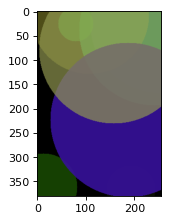

  0%|                                   | 100/350000 [00:13<13:42:26,  7.09it/s]

Iteration 0100 : best score = 6123.92463835, mean score = 6132.22070812.


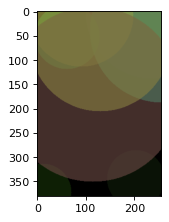

  0%|                                   | 200/350000 [00:27<12:53:46,  7.53it/s]

Iteration 0200 : best score = 5573.85151477, mean score = 5585.55193607.


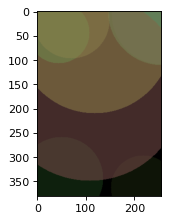

  0%|                                   | 300/350000 [00:41<12:59:54,  7.47it/s]

Iteration 0300 : best score = 5267.30262480, mean score = 5274.78231349.


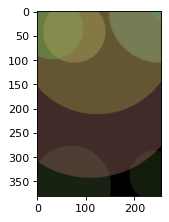

  0%|                                   | 400/350000 [00:54<13:11:18,  7.36it/s]

Adding circles 1th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.6309297535714575
Iteration 0400 : best score = 5168.18844298, mean score = 5172.74073216.


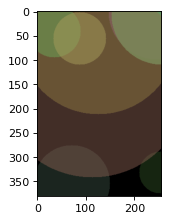

  0%|                                   | 500/350000 [01:08<12:50:51,  7.56it/s]

Iteration 0500 : best score = 4819.43548240, mean score = 4823.02743488.


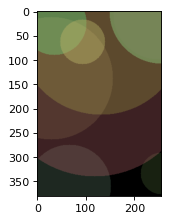

  0%|                                   | 600/350000 [01:22<12:58:30,  7.48it/s]

Adding circles 2th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.43067655807339306
Iteration 0600 : best score = 4726.58305185, mean score = 4739.05680304.


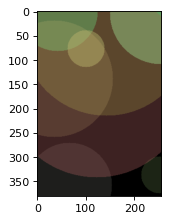

  0%|                                   | 700/350000 [01:36<12:56:15,  7.50it/s]

Iteration 0700 : best score = 4342.04010416, mean score = 4363.65186610.


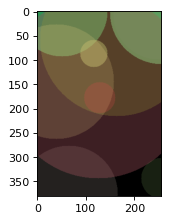

  0%|                                   | 800/350000 [01:49<13:08:10,  7.38it/s]

Iteration 0800 : best score = 4173.43745909, mean score = 4181.71089956.


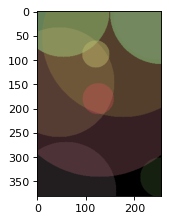

  0%|                                   | 900/350000 [02:03<13:05:30,  7.41it/s]

Iteration 0900 : best score = 4023.78948132, mean score = 4029.86464825.


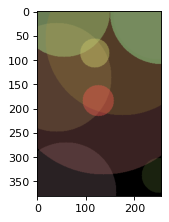

  0%|                                  | 1000/350000 [02:16<13:07:54,  7.38it/s]

Iteration 1000 : best score = 3818.06857050, mean score = 3836.25802676.


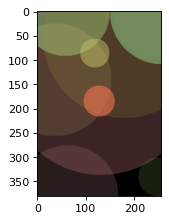

  0%|                                  | 1100/350000 [02:30<12:53:28,  7.52it/s]

Iteration 1100 : best score = 3752.26796127, mean score = 3757.48134324.


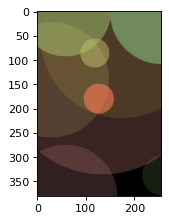

  0%|                                  | 1151/350000 [02:37<18:40:37,  5.19it/s]

Adding circles 3th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.3562071871080222


  0%|                                  | 1200/350000 [02:44<13:45:26,  7.04it/s]

Iteration 1200 : best score = 3547.51448618, mean score = 3556.68282650.


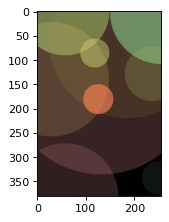

  0%|▏                                 | 1300/350000 [02:57<13:38:42,  7.10it/s]

Iteration 1300 : best score = 3369.39250748, mean score = 3378.42248518.


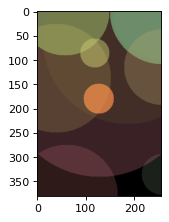

  0%|▏                                 | 1400/350000 [03:11<12:50:21,  7.54it/s]

Adding circles 4th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.31546487678572877
Iteration 1400 : best score = 3325.85926101, mean score = 3332.12658749.


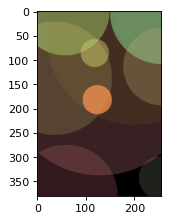

  0%|▏                                 | 1500/350000 [03:25<12:50:44,  7.54it/s]

Iteration 1500 : best score = 3257.44476369, mean score = 3260.55747596.


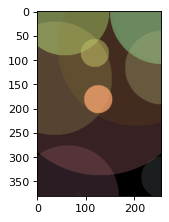

  0%|▏                                 | 1551/350000 [03:32<18:24:30,  5.26it/s]

Adding circles 5th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.2890648263178879


  0%|▏                                 | 1600/350000 [03:39<12:49:55,  7.54it/s]

Iteration 1600 : best score = 3239.15198397, mean score = 3239.90714532.


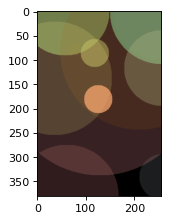

  0%|▏                                 | 1651/350000 [03:46<18:54:28,  5.12it/s]

Adding circles 6th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.27023815442731974


  0%|▏                                 | 1700/350000 [03:52<12:47:32,  7.56it/s]

Iteration 1700 : best score = 3157.16199844, mean score = 3158.94153390.


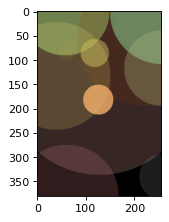

  1%|▏                                 | 1800/350000 [04:06<12:41:36,  7.62it/s]

Adding circles 7th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.2559580248098155
Iteration 1800 : best score = 3137.56775721, mean score = 3138.85671220.


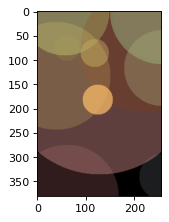

  1%|▏                                 | 1900/350000 [04:19<12:31:39,  7.72it/s]

Adding circles 8th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.24465054211822604
Iteration 1900 : best score = 3108.70667519, mean score = 3109.51127350.


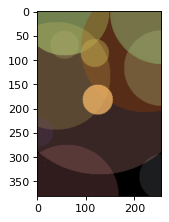

  1%|▏                                 | 2000/350000 [04:33<12:13:56,  7.90it/s]

Adding circles 9th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.23540891336663824
Iteration 2000 : best score = 3069.06331129, mean score = 3072.14477355.


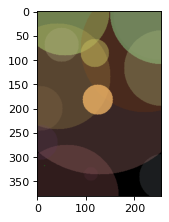

  1%|▏                                 | 2100/350000 [04:46<13:13:09,  7.31it/s]

Iteration 2100 : best score = 2846.61809248, mean score = 2856.46734045.


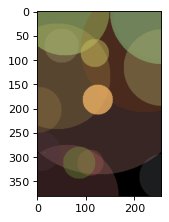

  1%|▏                                 | 2200/350000 [05:00<12:13:40,  7.90it/s]

Iteration 2200 : best score = 2783.82237422, mean score = 2786.40812863.


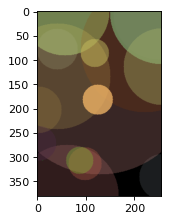

  1%|▏                                 | 2251/350000 [05:07<17:10:07,  5.63it/s]

Adding circles 10th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.227670248696953


  1%|▏                                 | 2300/350000 [05:13<12:38:53,  7.64it/s]

Iteration 2300 : best score = 2750.98213679, mean score = 2752.64486751.


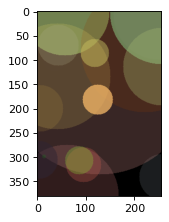

  1%|▏                                 | 2400/350000 [05:26<12:25:31,  7.77it/s]

Iteration 2400 : best score = 2675.80136682, mean score = 2679.23350335.


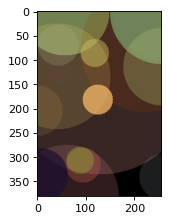

  1%|▏                                 | 2451/350000 [05:33<17:33:28,  5.50it/s]

Adding circles 11th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.22106472945750374


  1%|▏                                 | 2500/350000 [05:39<12:27:02,  7.75it/s]

Iteration 2500 : best score = 2639.88241853, mean score = 2645.11239707.


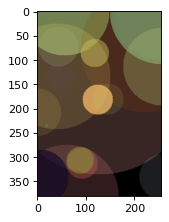

  1%|▏                                 | 2551/350000 [05:46<17:22:36,  5.55it/s]

Adding circles 12th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.21533827903669653


  1%|▎                                 | 2600/350000 [05:53<13:55:44,  6.93it/s]

Iteration 2600 : best score = 2632.74981934, mean score = 2633.05604455.


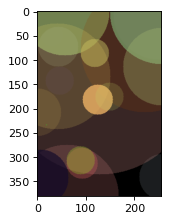

  1%|▎                                 | 2651/350000 [06:00<17:31:10,  5.51it/s]

Adding circles 13th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.2103099178571525


  1%|▎                                 | 2700/350000 [06:06<12:09:44,  7.93it/s]

Iteration 2700 : best score = 2604.35956908, mean score = 2605.43111225.


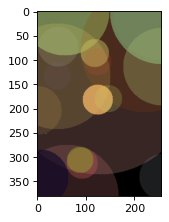

  1%|▎                                 | 2751/350000 [06:13<17:26:42,  5.53it/s]

Adding circles 14th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.20584683246043448


  1%|▎                                 | 2800/350000 [06:19<12:27:55,  7.74it/s]

Iteration 2800 : best score = 2583.61960496, mean score = 2584.47496083.


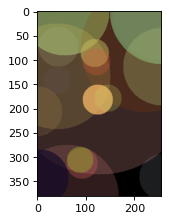

  1%|▎                                 | 2851/350000 [06:26<17:10:47,  5.61it/s]

Adding circles 15th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.20184908658209985


  1%|▎                                 | 2900/350000 [06:32<12:35:50,  7.65it/s]

Iteration 2900 : best score = 2549.56504625, mean score = 2551.50270451.


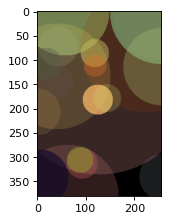

  1%|▎                                 | 2951/350000 [06:39<17:18:25,  5.57it/s]

Adding circles 16th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.19823986317056053


  1%|▎                                 | 3000/350000 [06:45<12:15:29,  7.86it/s]

Iteration 3000 : best score = 2499.90502137, mean score = 2500.72927918.


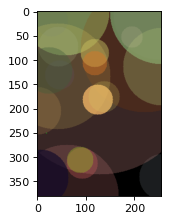

  1%|▎                                 | 3051/350000 [06:52<17:40:13,  5.45it/s]

Adding circles 17th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.1949590218937863


  1%|▎                                 | 3100/350000 [06:58<12:16:34,  7.85it/s]

Iteration 3100 : best score = 2472.39296070, mean score = 2472.96146178.


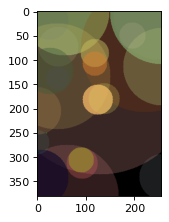

  1%|▎                                 | 3151/350000 [07:05<17:32:59,  5.49it/s]

Adding circles 18th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.19195872000656014


  1%|▎                                 | 3200/350000 [07:11<12:06:57,  7.95it/s]

Iteration 3200 : best score = 2431.97347804, mean score = 2434.98782641.


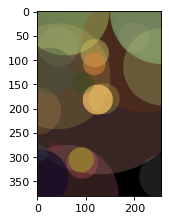

  1%|▎                                 | 3300/350000 [07:24<12:06:10,  7.96it/s]

Adding circles 19th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.18920035951687003
Iteration 3300 : best score = 2420.85770262, mean score = 2421.33217338.


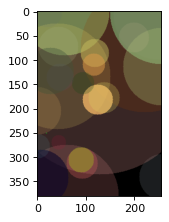

  1%|▎                                 | 3400/350000 [07:37<12:11:12,  7.90it/s]

Iteration 3400 : best score = 2378.65349751, mean score = 2380.82036861.


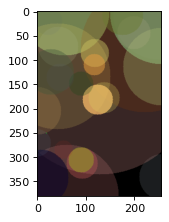

  1%|▎                                 | 3451/350000 [07:44<17:11:02,  5.60it/s]

Adding circles 20th time. 
                                      
 Split target image into 4 rectangles.
                                      
 Radius_scale=0.18665241123894338


  1%|▎                                 | 3500/350000 [07:50<12:08:07,  7.93it/s]

Iteration 3500 : best score = 2353.32199125, mean score = 2354.38271640.


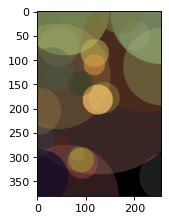

  1%|▎                                 | 3551/350000 [07:57<18:39:24,  5.16it/s]

Adding circles 21th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.18428883314870617


  1%|▎                                 | 3600/350000 [08:04<12:23:04,  7.77it/s]

Iteration 3600 : best score = 2330.96395626, mean score = 2332.29311902.


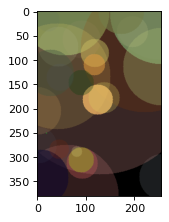

  1%|▎                                 | 3651/350000 [08:11<17:35:56,  5.47it/s]

Adding circles 22th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.18208790046993825


  1%|▎                                 | 3700/350000 [08:17<12:28:07,  7.71it/s]

Iteration 3700 : best score = 2308.99854408, mean score = 2310.64536260.


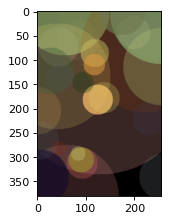

  1%|▎                                 | 3751/350000 [08:24<18:11:45,  5.29it/s]

Adding circles 23th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.18003132665669264


  1%|▎                                 | 3800/350000 [08:30<12:08:52,  7.92it/s]

Iteration 3800 : best score = 2270.71289195, mean score = 2273.31867347.


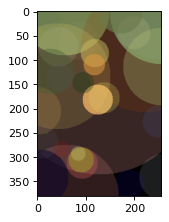

  1%|▎                                 | 3851/350000 [08:37<17:32:14,  5.48it/s]

Adding circles 24th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.1781035935540111


  1%|▍                                 | 3900/350000 [08:44<12:14:09,  7.86it/s]

Iteration 3900 : best score = 2256.78764726, mean score = 2258.69426471.


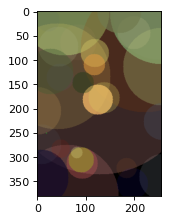

  1%|▍                                 | 3951/350000 [08:51<17:29:19,  5.50it/s]

Adding circles 25th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.17629143438888212


  1%|▍                                 | 4000/350000 [08:57<12:51:28,  7.47it/s]

Iteration 4000 : best score = 2236.62312292, mean score = 2237.41713818.


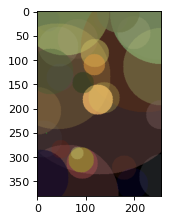

  1%|▍                                 | 4051/350000 [09:04<17:21:10,  5.54it/s]

Adding circles 26th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.17458343004804494


  1%|▍                                 | 4100/350000 [09:10<12:25:11,  7.74it/s]

Iteration 4100 : best score = 2224.90888848, mean score = 2225.28311551.


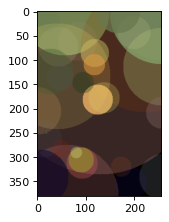

  1%|▍                                 | 4151/350000 [09:17<17:13:39,  5.58it/s]

Adding circles 27th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.1729696904450771


  1%|▍                                 | 4200/350000 [09:23<12:12:36,  7.87it/s]

Iteration 4200 : best score = 2131.54468591, mean score = 2135.70118485.


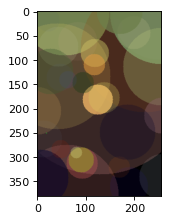

  1%|▍                                 | 4300/350000 [09:36<12:15:59,  7.83it/s]

Adding circles 28th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.17144160057391347
Iteration 4300 : best score = 2110.96434448, mean score = 2112.09336122.


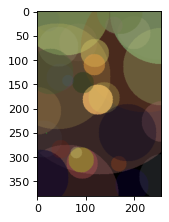

  1%|▍                                 | 4400/350000 [09:49<12:15:34,  7.83it/s]

Adding circles 29th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.16999161628691403
Iteration 4400 : best score = 2095.83550969, mean score = 2096.95637986.


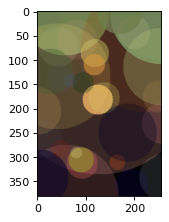

  1%|▍                                 | 4500/350000 [10:03<13:34:18,  7.07it/s]

Adding circles 30th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.1686130986895011
Iteration 4500 : best score = 2089.38423635, mean score = 2089.79146937.


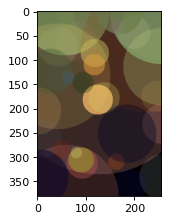

  1%|▍                                 | 4600/350000 [10:16<12:08:35,  7.90it/s]

Iteration 4600 : best score = 2035.09458387, mean score = 2035.75514140.


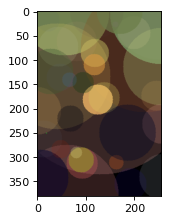

  1%|▍                                 | 4651/350000 [10:23<17:13:46,  5.57it/s]

Adding circles 31th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.16730017881017412


  1%|▍                                 | 4700/350000 [10:30<12:43:21,  7.54it/s]

Iteration 4700 : best score = 2023.93481331, mean score = 2024.43268336.


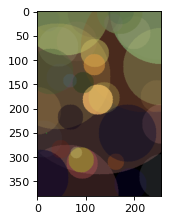

  1%|▍                                 | 4751/350000 [10:37<17:18:10,  5.54it/s]

Adding circles 32th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.16604764621593782


  1%|▍                                 | 4800/350000 [10:43<12:31:31,  7.66it/s]

Iteration 4800 : best score = 1997.19041008, mean score = 1998.11233771.


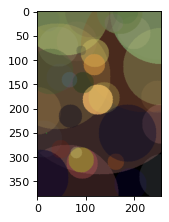

  1%|▍                                 | 4851/350000 [10:50<18:17:42,  5.24it/s]

Adding circles 33th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.16485085672216038


  1%|▍                                 | 4900/350000 [10:57<13:42:36,  6.99it/s]

Iteration 4900 : best score = 1989.84365633, mean score = 1990.97972314.


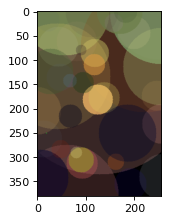

  1%|▍                                 | 4951/350000 [11:04<18:32:16,  5.17it/s]

Adding circles 34th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.16370565544521565


  1%|▍                                 | 5000/350000 [11:10<13:03:56,  7.33it/s]

Iteration 5000 : best score = 1966.26019978, mean score = 1968.11986733.


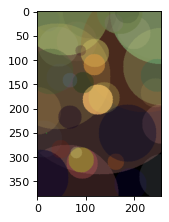

  1%|▍                                 | 5051/350000 [11:17<17:07:41,  5.59it/s]

Adding circles 35th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.16260831227163416


  1%|▍                                 | 5100/350000 [11:24<12:37:27,  7.59it/s]

Iteration 5100 : best score = 1958.87722155, mean score = 1959.32174880.


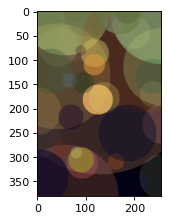

  1%|▌                                 | 5150/350000 [11:30<13:23:03,  7.16it/s]

Adding circles 36th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.16155546744299637


  1%|▌                                 | 5200/350000 [11:37<12:39:56,  7.56it/s]

Iteration 5200 : best score = 1938.82137089, mean score = 1939.98781961.


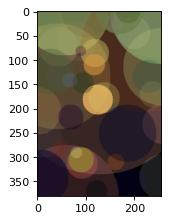

  2%|▌                                 | 5300/350000 [11:50<12:16:23,  7.80it/s]

Adding circles 37th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.1605440854340214
Iteration 5300 : best score = 1914.93626484, mean score = 1915.41569165.


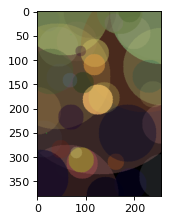

  2%|▌                                 | 5400/350000 [12:03<12:08:53,  7.88it/s]

Iteration 5400 : best score = 1846.58026672, mean score = 1847.64045110.


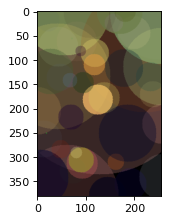

  2%|▌                                 | 5451/350000 [12:10<17:29:05,  5.47it/s]

Adding circles 38th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.15957141566993818


  2%|▌                                 | 5500/350000 [12:16<12:12:28,  7.84it/s]

Iteration 5500 : best score = 1818.91466055, mean score = 1820.51716861.


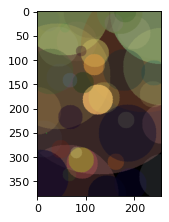

  2%|▌                                 | 5551/350000 [12:23<17:11:14,  5.57it/s]

Adding circles 39th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.15863495891559604


  2%|▌                                 | 5600/350000 [12:30<12:16:27,  7.79it/s]

Iteration 5600 : best score = 1804.93557703, mean score = 1806.11092020.


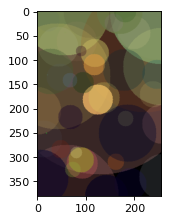

  2%|▌                                 | 5651/350000 [12:36<17:15:12,  5.54it/s]

Adding circles 40th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.15773243839286438


  2%|▌                                 | 5700/350000 [12:43<12:10:50,  7.85it/s]

Iteration 5700 : best score = 1787.59164689, mean score = 1788.16974641.


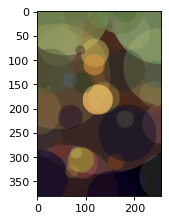

  2%|▌                                 | 5751/350000 [12:49<16:41:51,  5.73it/s]

Adding circles 41th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.156861774859441


  2%|▌                                 | 5800/350000 [12:56<12:02:45,  7.94it/s]

Iteration 5800 : best score = 1774.04342963, mean score = 1774.87161078.


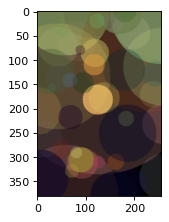

  2%|▌                                 | 5851/350000 [13:02<17:03:08,  5.61it/s]

Adding circles 42th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.15602106502222501


  2%|▌                                 | 5900/350000 [13:09<12:15:10,  7.80it/s]

Iteration 5900 : best score = 1747.67003909, mean score = 1748.58620736.


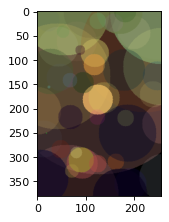

  2%|▌                                 | 5951/350000 [13:16<17:36:27,  5.43it/s]

Adding circles 43th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.15520856277015513


  2%|▌                                 | 6000/350000 [13:22<12:28:31,  7.66it/s]

Iteration 6000 : best score = 1733.83159318, mean score = 1735.07933396.


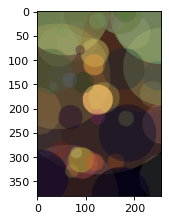

  2%|▌                                 | 6051/350000 [13:29<16:57:40,  5.63it/s]

Adding circles 44th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.15442266280111014


  2%|▌                                 | 6100/350000 [13:35<11:55:42,  8.01it/s]

Iteration 6100 : best score = 1724.09351986, mean score = 1725.22624411.


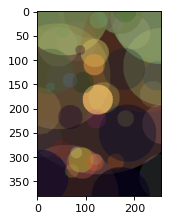

  2%|▌                                 | 6151/350000 [13:42<17:30:20,  5.46it/s]

Adding circles 45th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.15366188628986424


  2%|▌                                 | 6200/350000 [13:48<12:57:39,  7.37it/s]

Iteration 6200 : best score = 1721.40741664, mean score = 1721.74002716.


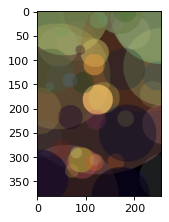

  2%|▌                                 | 6251/350000 [13:55<16:53:33,  5.65it/s]

Adding circles 46th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.15292486830283214


  2%|▌                                 | 6300/350000 [14:01<11:58:32,  7.97it/s]

Iteration 6300 : best score = 1709.97362886, mean score = 1710.23072208.


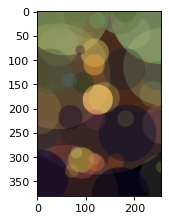

  2%|▌                                 | 6351/350000 [14:08<16:32:21,  5.77it/s]

Adding circles 47th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.15221034671324338


  2%|▌                                 | 6400/350000 [14:14<12:30:19,  7.63it/s]

Iteration 6400 : best score = 1698.99754665, mean score = 1699.63013625.


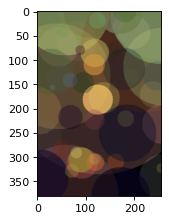

  2%|▋                                 | 6451/350000 [14:21<16:23:07,  5.82it/s]

Adding circles 48th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.1515171524096389


  2%|▋                                 | 6500/350000 [14:27<11:39:30,  8.18it/s]

Iteration 6500 : best score = 1683.15218489, mean score = 1683.62298188.


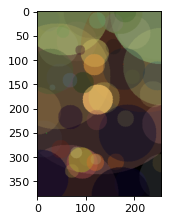

  2%|▋                                 | 6551/350000 [14:34<16:24:01,  5.82it/s]

Adding circles 49th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.15084420062289414


  2%|▋                                 | 6600/350000 [14:40<11:40:26,  8.17it/s]

Iteration 6600 : best score = 1670.96445899, mean score = 1671.19923488.


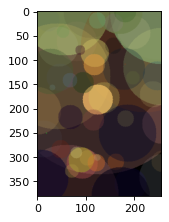

  2%|▋                                 | 6651/350000 [14:46<16:52:25,  5.65it/s]

Adding circles 50th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.15019048322368797


  2%|▋                                 | 6700/350000 [14:53<12:07:04,  7.87it/s]

Iteration 6700 : best score = 1659.98136843, mean score = 1660.14815172.


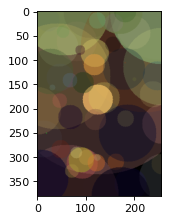

  2%|▋                                 | 6751/350000 [15:00<17:06:19,  5.57it/s]

Adding circles 51th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.14955506186451523


  2%|▋                                 | 6800/350000 [15:06<12:18:34,  7.74it/s]

Iteration 6800 : best score = 1651.90635931, mean score = 1652.52230945.


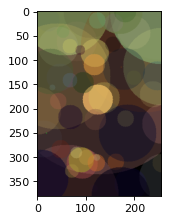

  2%|▋                                 | 6851/350000 [15:12<16:11:46,  5.89it/s]

Adding circles 52th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.14893706185882832


  2%|▋                                 | 6900/350000 [15:18<11:51:53,  8.03it/s]

Iteration 6900 : best score = 1647.78621531, mean score = 1648.03390461.


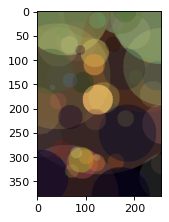

  2%|▋                                 | 6951/350000 [15:25<16:14:14,  5.87it/s]

Adding circles 53th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.14833566670536175


  2%|▋                                 | 7000/350000 [15:31<11:30:41,  8.28it/s]

Iteration 7000 : best score = 1638.43043231, mean score = 1639.66170067.


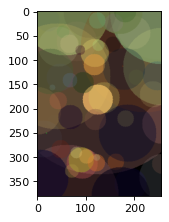

  2%|▋                                 | 7100/350000 [15:43<11:53:55,  8.01it/s]

Iteration 7100 : best score = 1607.80221520, mean score = 1608.37584171.


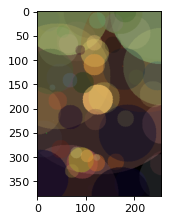

  2%|▋                                 | 7151/350000 [15:50<16:28:01,  5.78it/s]

Adding circles 54th time. 
                                      
 Split target image into 16 rectangles.
                                      
 Radius_scale=0.1477501131786861


  2%|▋                                 | 7200/350000 [15:56<11:41:58,  8.14it/s]

Iteration 7200 : best score = 1591.02098463, mean score = 1592.45862238.


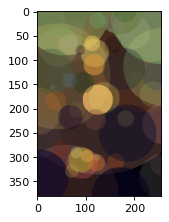

  2%|▋                                 | 7251/350000 [16:03<16:31:04,  5.76it/s]

Adding circles 55th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.14717968691798522


  2%|▋                                 | 7300/350000 [16:09<12:02:03,  7.91it/s]

Iteration 7300 : best score = 1569.63244542, mean score = 1570.83995175.


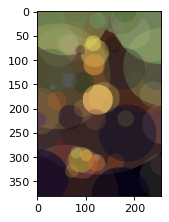

  2%|▋                                 | 7400/350000 [16:21<11:42:10,  8.13it/s]

Adding circles 56th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.14662371845531105
Iteration 7400 : best score = 1551.19611364, mean score = 1551.59367357.


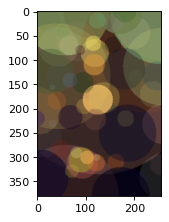

  2%|▋                                 | 7500/350000 [16:34<11:30:52,  8.26it/s]

Iteration 7500 : best score = 1520.97176271, mean score = 1522.04205044.


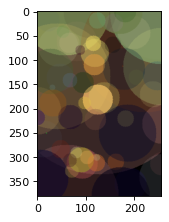

  2%|▋                                 | 7551/350000 [16:40<16:19:46,  5.83it/s]

Adding circles 57th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.14608157963242446


  2%|▋                                 | 7600/350000 [16:46<11:29:54,  8.27it/s]

Iteration 7600 : best score = 1494.73969783, mean score = 1495.82771444.


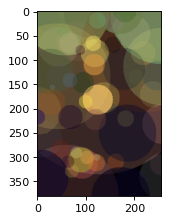

  2%|▋                                 | 7651/350000 [16:53<16:39:12,  5.71it/s]

Adding circles 58th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.14555268036201674


  2%|▋                                 | 7700/350000 [16:59<11:30:35,  8.26it/s]

Iteration 7700 : best score = 1484.44259534, mean score = 1485.40398081.


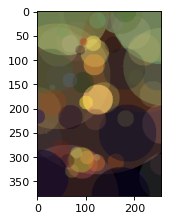

  2%|▊                                 | 7751/350000 [17:05<16:18:55,  5.83it/s]

Adding circles 59th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.14503646569481302


  2%|▊                                 | 7800/350000 [17:11<11:24:43,  8.33it/s]

Iteration 7800 : best score = 1466.55508593, mean score = 1467.16864965.


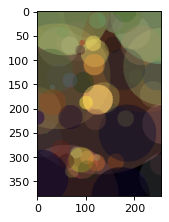

  2%|▊                                 | 7851/350000 [17:17<16:17:13,  5.84it/s]

Adding circles 60th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.14453241315894394


  2%|▊                                 | 7900/350000 [17:23<11:15:29,  8.44it/s]

Iteration 7900 : best score = 1456.48840887, mean score = 1457.04542322.


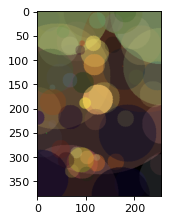

  2%|▊                                 | 7951/350000 [17:30<17:54:53,  5.30it/s]

Adding circles 61th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.1440400303421672


  2%|▊                                 | 8000/350000 [17:36<12:21:42,  7.68it/s]

Iteration 8000 : best score = 1452.98353168, mean score = 1453.20696972.


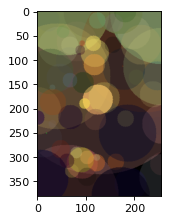

  2%|▊                                 | 8051/350000 [17:43<17:04:52,  5.56it/s]

Adding circles 62th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.14355885269113103


  2%|▊                                 | 8100/350000 [17:49<11:59:07,  7.92it/s]

Iteration 8100 : best score = 1446.82216744, mean score = 1447.02517368.


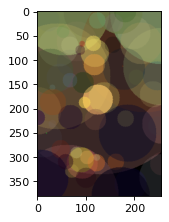

  2%|▊                                 | 8151/350000 [17:56<16:26:59,  5.77it/s]

Adding circles 63th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.14308844150498737


  2%|▊                                 | 8200/350000 [18:02<11:53:34,  7.98it/s]

Iteration 8200 : best score = 1438.65132815, mean score = 1438.80350060.


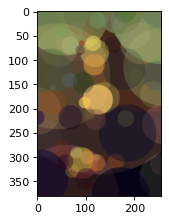

  2%|▊                                 | 8251/350000 [18:08<17:14:49,  5.50it/s]

Adding circles 64th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.14262838210336


  2%|▊                                 | 8300/350000 [18:15<11:55:53,  7.96it/s]

Iteration 8300 : best score = 1430.06163573, mean score = 1430.41258938.


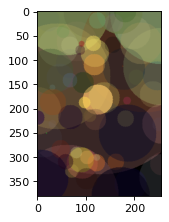

  2%|▊                                 | 8351/350000 [18:21<17:14:19,  5.51it/s]

Adding circles 65th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.14217828215101067


  2%|▊                                 | 8400/350000 [18:28<11:55:05,  7.96it/s]

Iteration 8400 : best score = 1424.77592793, mean score = 1425.34026172.


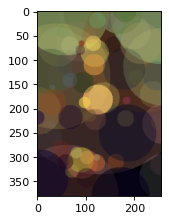

  2%|▊                                 | 8451/350000 [18:34<17:20:06,  5.47it/s]

Adding circles 66th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.1417377701235801


  2%|▊                                 | 8500/350000 [18:41<12:06:31,  7.83it/s]

Iteration 8500 : best score = 1412.50889074, mean score = 1413.43275579.


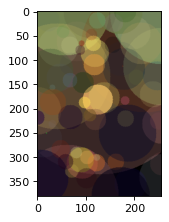

  2%|▊                                 | 8551/350000 [18:47<17:00:41,  5.58it/s]

Adding circles 67th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.14130649390055278


  2%|▊                                 | 8600/350000 [18:53<12:03:30,  7.86it/s]

Iteration 8600 : best score = 1399.53950737, mean score = 1399.85298590.


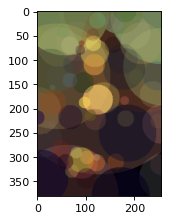

  2%|▊                                 | 8651/350000 [19:00<16:57:24,  5.59it/s]

Adding circles 68th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.1408841194731412


  2%|▊                                 | 8700/350000 [19:07<12:02:22,  7.87it/s]

Iteration 8700 : best score = 1392.55679157, mean score = 1392.82125173.


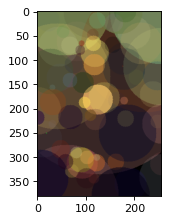

  3%|▊                                 | 8751/350000 [19:13<17:09:09,  5.53it/s]

Adding circles 69th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.14047032975614


  3%|▊                                 | 8800/350000 [19:19<11:35:41,  8.17it/s]

Iteration 8800 : best score = 1379.83016964, mean score = 1381.03443632.


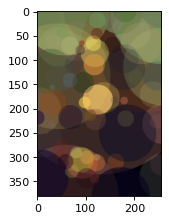

  3%|▊                                 | 8851/350000 [19:26<16:45:59,  5.65it/s]

Adding circles 70th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.14006482349398794


  3%|▊                                 | 8900/350000 [19:32<11:53:27,  7.97it/s]

Iteration 8900 : best score = 1371.56760934, mean score = 1371.91650959.


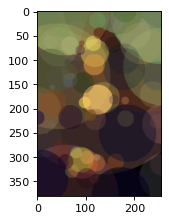

  3%|▊                                 | 8951/350000 [19:39<16:50:55,  5.62it/s]

Adding circles 71th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.1396673142523192


  3%|▊                                 | 9000/350000 [19:45<11:25:04,  8.30it/s]

Iteration 9000 : best score = 1367.88258163, mean score = 1367.96333867.


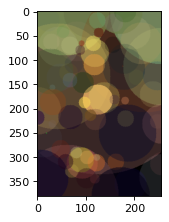

  3%|▉                                 | 9051/350000 [19:51<16:42:42,  5.67it/s]

Adding circles 72th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.13927752948720412


  3%|▉                                 | 9100/350000 [19:58<12:05:03,  7.84it/s]

Iteration 9100 : best score = 1343.27109443, mean score = 1343.54681628.


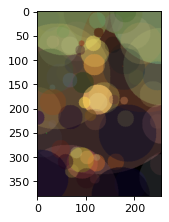

  3%|▉                                 | 9151/350000 [20:05<17:28:26,  5.42it/s]

Adding circles 73th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.13889520968509134


  3%|▉                                 | 9200/350000 [20:11<12:36:15,  7.51it/s]

Iteration 9200 : best score = 1330.74249286, mean score = 1331.12045363.


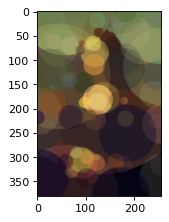

  3%|▉                                 | 9251/350000 [20:18<16:56:58,  5.58it/s]

Adding circles 74th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.13852010756717748


  3%|▉                                 | 9300/350000 [20:24<12:24:08,  7.63it/s]

Iteration 9300 : best score = 1318.38012657, mean score = 1319.13391616.


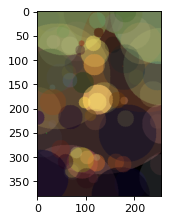

  3%|▉                                 | 9351/350000 [20:31<17:30:32,  5.40it/s]

Adding circles 75th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.1381519873525671


  3%|▉                                 | 9400/350000 [20:38<12:23:44,  7.63it/s]

Iteration 9400 : best score = 1312.67426501, mean score = 1313.00303063.


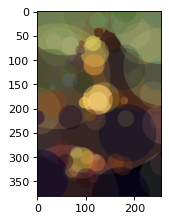

  3%|▉                                 | 9451/350000 [20:45<17:42:36,  5.34it/s]

Adding circles 76th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.13779062407514628


  3%|▉                                 | 9500/350000 [20:51<12:33:56,  7.53it/s]

Iteration 9500 : best score = 1310.25517472, mean score = 1310.42580989.


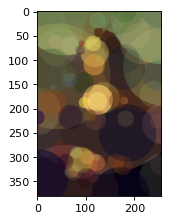

  3%|▉                                 | 9551/350000 [20:58<17:32:23,  5.39it/s]

Adding circles 77th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.13743580294959373


  3%|▉                                 | 9600/350000 [21:04<12:02:00,  7.86it/s]

Iteration 9600 : best score = 1306.28286311, mean score = 1306.37674660.


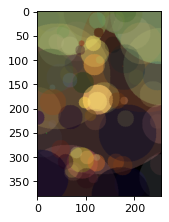

  3%|▉                                 | 9651/350000 [21:11<17:11:34,  5.50it/s]

Adding circles 78th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.13708731878239783


  3%|▉                                 | 9700/350000 [21:17<12:03:21,  7.84it/s]

Iteration 9700 : best score = 1302.88346962, mean score = 1303.20632715.


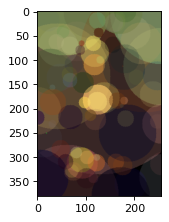

  3%|▉                                 | 9750/350000 [21:23<11:56:16,  7.92it/s]

Adding circles 79th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.1367449754241439


  3%|▉                                 | 9800/350000 [21:30<12:15:16,  7.71it/s]

Iteration 9800 : best score = 1299.03809269, mean score = 1299.16364954.


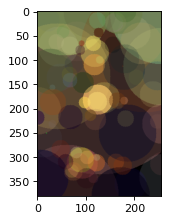

  3%|▉                                 | 9851/350000 [21:37<17:29:05,  5.40it/s]

Adding circles 80th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.13640858525969024


  3%|▉                                 | 9900/350000 [21:43<12:08:48,  7.78it/s]

Iteration 9900 : best score = 1295.98771112, mean score = 1296.15154384.


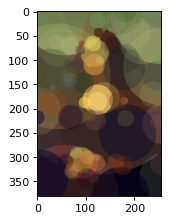

  3%|▉                                 | 9951/350000 [21:50<17:08:09,  5.51it/s]

Adding circles 81th time. 
                                      
 Split target image into 64 rectangles.
                                      
 Radius_scale=0.13607796873316694


  3%|▉                                | 10000/350000 [21:57<12:20:08,  7.66it/s]

Iteration 10000 : best score = 1295.14172916, mean score = 1295.30045881.


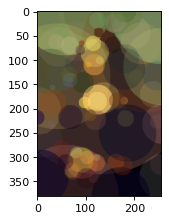

  3%|▉                                | 10041/350000 [22:02<12:03:19,  7.83it/s]

In [ ]:
best_solution_objective_value, best_solution, best_solution_background,\
log_objective_values, log_best_solutions, log_best_backgrounds , \
log_sigmas_mean = es_model.train(
                                  number_of_iterations=350000,
                                  number_of_parents=6, 
                                  number_of_offspring_per_parent=3, 
                                  max_chromosome_length=256,
                                  initial_sigma_scale=5e-2,
                                  add_cricle_threshold=1e-2,
                                  log_frequency=100,
                                  update_frequency=50
    )

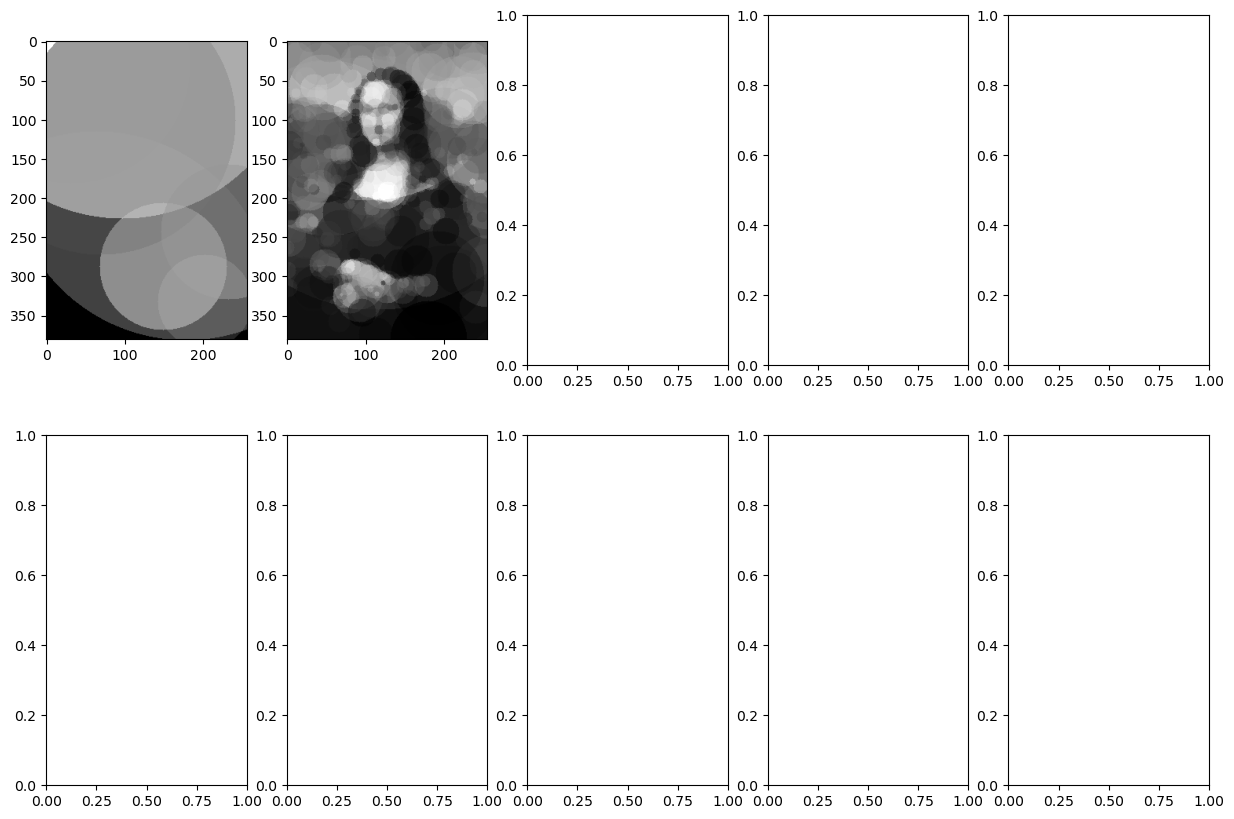

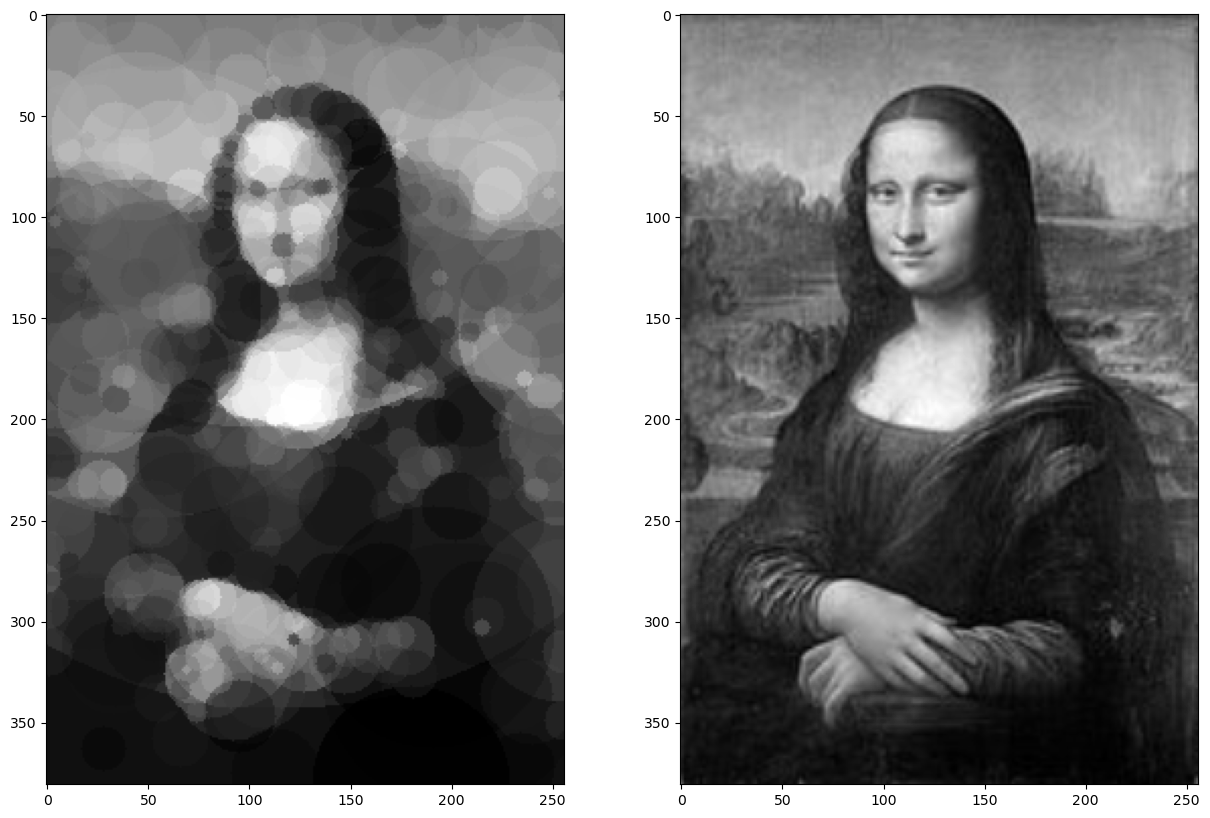

In [90]:
#mod_val=(10+len(log_best_solutions))//10

fig, axs = plt.subplots(2, 5, figsize=(15,10))
col_counter=0
row_counter=0
for i, X in enumerate(log_best_solutions):
   # if i%mod_val==0:
        axs[row_counter, col_counter].imshow(es_model.represent_individual(X, log_best_backgrounds[i]), cmap='gray')
        col_counter+=1
        if col_counter>4:
            col_counter=0
            row_counter+=1
        #draw_individual(represent_individual(X))
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(es_model.represent_individual(best_solution, best_solution_background), cmap='gray')
axs[1].imshow(es_model.target_img, cmap='gray')
plt.show()

/tmp/ipykernel_3023347/1237498512.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(log_objective_values[:,0]))


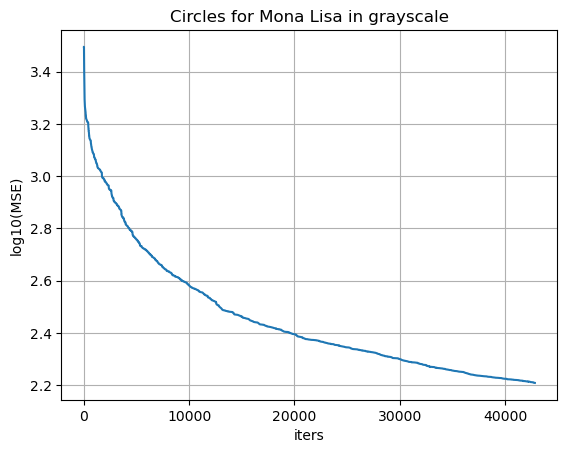

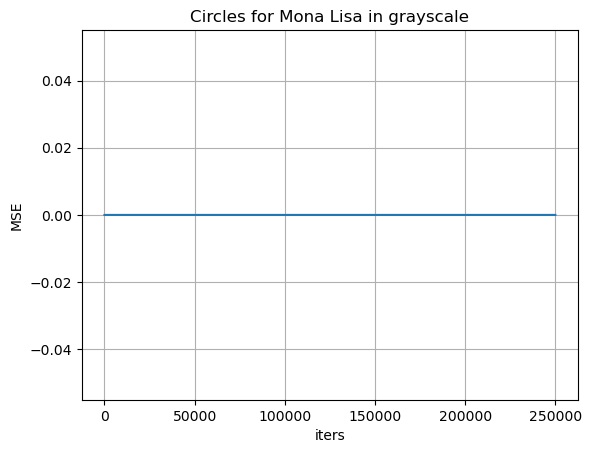

In [91]:
plt.plot(np.log10(log_objective_values[:,0]))
plt.grid()
plt.title("Circles for Mona Lisa in grayscale")
plt.ylabel('log10(MSE)')
plt.xlabel('iters')

plt.show()

plt.plot(log_objective_values[100000:,2])
plt.grid()
plt.title("Circles for Mona Lisa in grayscale")
plt.ylabel('MSE')
plt.xlabel('iters')
#plt.ylim(bottom=600)

plt.show()

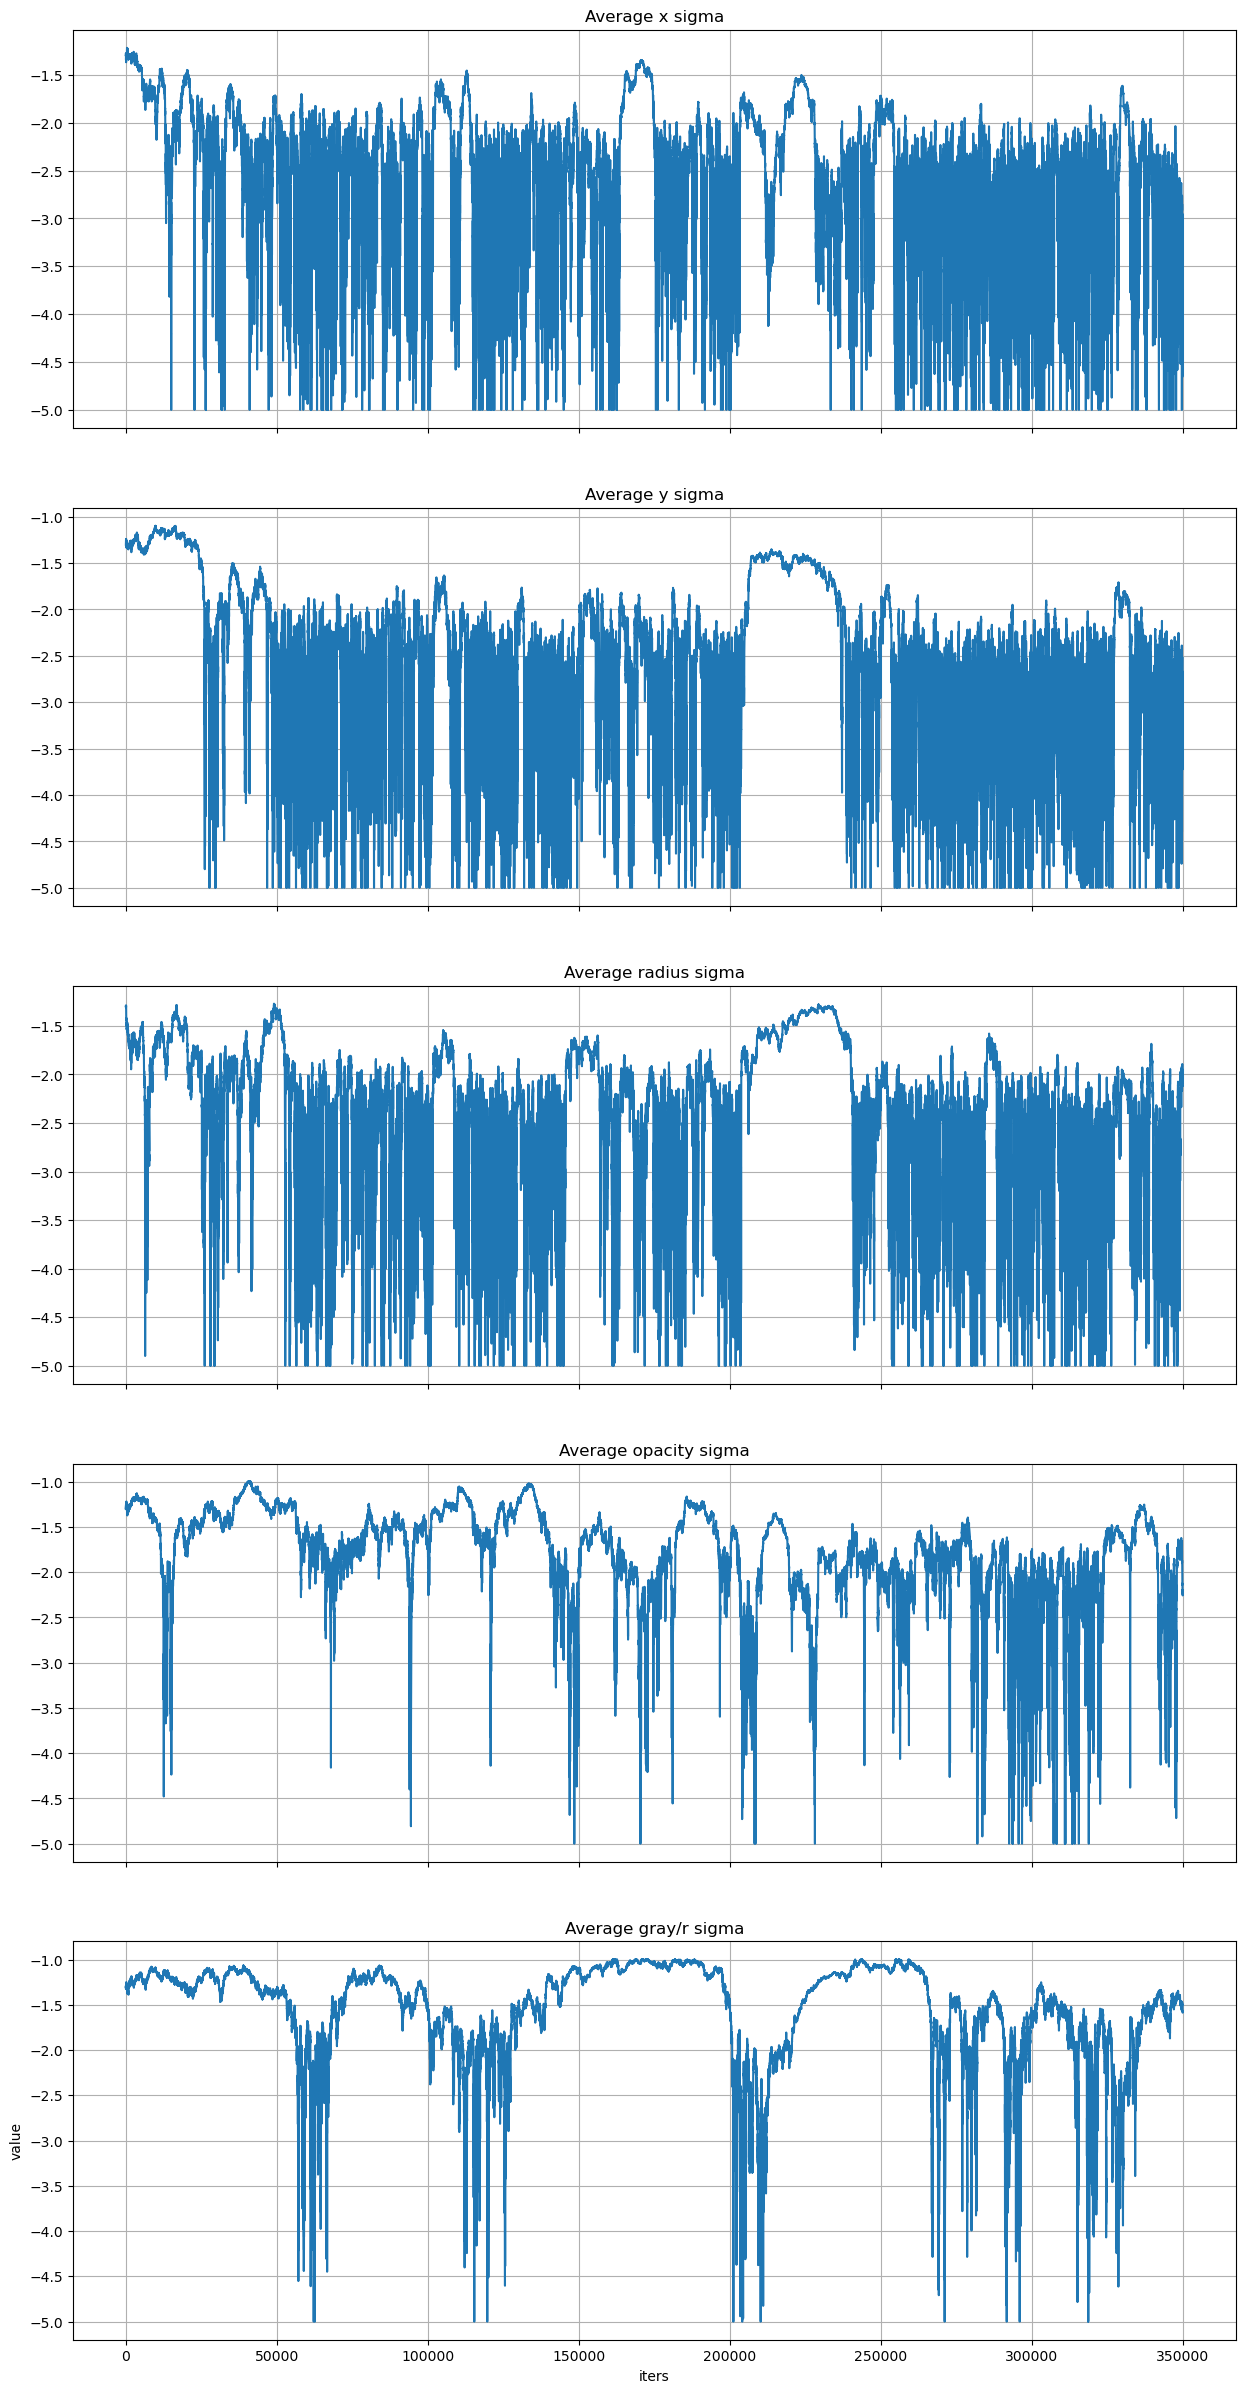

In [83]:
sigmas_params={0:'x', 1:'y', 2:'radius', 3:'opacity', 4:'gray/r', 5:'g', 6:'b'}

fig, axs = plt.subplots(es_model.genotype_length, 1, figsize=(15,30), sharex=True)

for i in range(es_model.genotype_length):
    axs[i].plot(np.log10(log_sigmas_mean[:,i]), label=sigmas_params[i])
    axs[i].grid()
    axs[i].set_title(f"Average {sigmas_params[i]} sigma")
    plt.ylabel('value')
plt.xlabel('iters')
#plt.legend()

plt.show()

/home/kacper/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


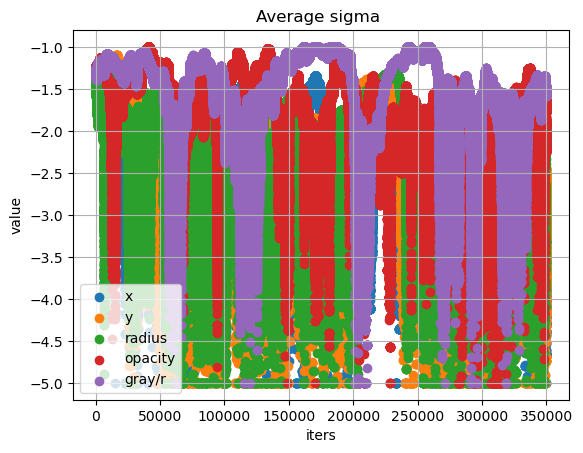

In [74]:
sigmas_params={0:'x', 1:'y', 2:'radius', 3:'opacity', 4:'gray/r', 5:'g', 6:'b'}

for i in range(es_model.genotype_length):
    plt.plot(np.log10(log_sigmas_mean[:,i]), label=sigmas_params[i])

plt.grid()
plt.title("Average sigma ")
plt.ylabel('value')
plt.xlabel('iters')
plt.legend()
#plt.ylim(top=0.05)

plt.show()